# Analysis of Large Scale Social Networks

- **Kin Ho Chan:** r0772534
- **Loris Gallo:** r0906521
- **Hrishikesh Nambiar:** r0909789
- **Milton Ossamu Tanizaka Filho:** r0822517

## Considerations

Dataset extracted from https://snap.stanford.edu/data/amazon0302.html
- Amazon network https://snap.stanford.edu/data/amazon0302.html
- Metadata https://snap.stanford.edu/data/amazon-meta.html

## Importings

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import time
import itertools
import warnings
import pickle

warnings.filterwarnings('ignore')

In [123]:
print('Version of pandas:', pd.__version__)
print('Version of numpy:', np.__version__)
print('Version of seaborn:', sns.__version__)
print('Version of igraph:', ig.__version__)

Version of pandas: 1.3.4
Version of numpy: 1.20.3
Version of seaborn: 0.11.2
Version of igraph: 0.9.10


## Dataset

### Metadata

Treating metadata and organizing into a pandas dataframe

In [3]:
# # read all lines of the meta data into content list
# with open('amazon-meta.txt', encoding='utf8') as f:
#     content = f.readlines()

In [4]:
# # remove the beginning and trailing white spaces
# content = [x.strip() for x in content]

In [5]:
# # Write extracted information to testfile.txt in a format of ',' demilited files.
# # The columns are Id, title, group, categories, totalreviews, avgrating.
# # The code stores all extracted information about a product into previoulines,
# # and write the content into file only when all information are available. Hence,
# # if review information for a product is not available, the product won't appear
# # in the final file.
# file = open("testfile.txt","w", encoding='utf8')
# previouslines = ['Id', 'title', 'group', 'categories', 'totalreviews', 'avgrating']
# for line in content:
#     lines = line.split(':')
#     if lines[0] == "Id":
#         if (len(previouslines) == 6):
#             for component in previouslines[0:5]:
#                 file.write(component)
#                 file.write(',')
#             file.write(previouslines[5])
#             file.write("\n")
#         previouslines = []
#         previouslines.append(lines[1].strip())
        
#     if lines[0] == "title":
#         title = ':'.join(lines[1:]).strip().replace(',', ' ').replace('\n', ' ').strip()
#         previouslines.append(title)
       
#     if lines[0] == "group":
#         previouslines.append(lines[1].strip())

#     if lines[0] == "categories":
#         previouslines.append(lines[1].strip())
    
#     if lines[0] == "reviews" and lines[1].strip() == "total":
#         previouslines.append(lines[2].split(' ')[1])
#         previouslines.append(lines[4].strip())
# file.close()

In [2]:
# metadata
desc = pd.read_csv('testfile.txt')

In [7]:
desc.head()

,Id,title,group,categories,totalreviews,avgrating
0,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,2,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,2,0,0.0


#### EDA

In [7]:
# unique values of each column
desc.nunique()

Id              542683
title           499796
group               10
categories          90
totalreviews       958
avgrating           10
dtype: int64

In [8]:
# number of items by group
desc['group'].value_counts()

Book            393561
Music           103143
Video            26131
DVD              19828
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: group, dtype: int64

In [3]:
# considering only book, music, dvd, and video
desc = desc[desc['group'].isin(['Book', 'Music', 'DVD', 'Video'])]

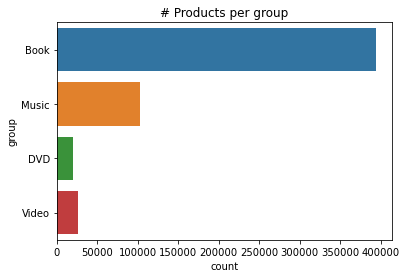

In [25]:
plt.title('# Products per group')
sns.countplot(data=desc, y='group');

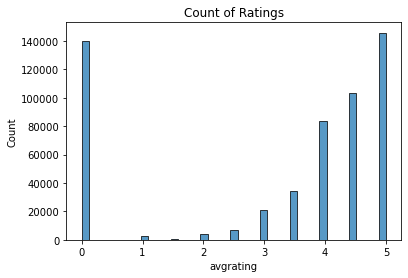

In [26]:
plt.title('Count of Ratings')
sns.histplot(data=desc, x='avgrating');

<AxesSubplot:title={'center':'Average rating per group'}, xlabel='group', ylabel='avgrating'>

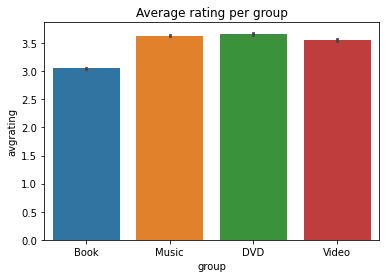

In [5]:
plt.title('Average rating per group')
sns.barplot(data=desc, x='group', y='avgrating')

In [15]:
desc['categories'].nunique()

90

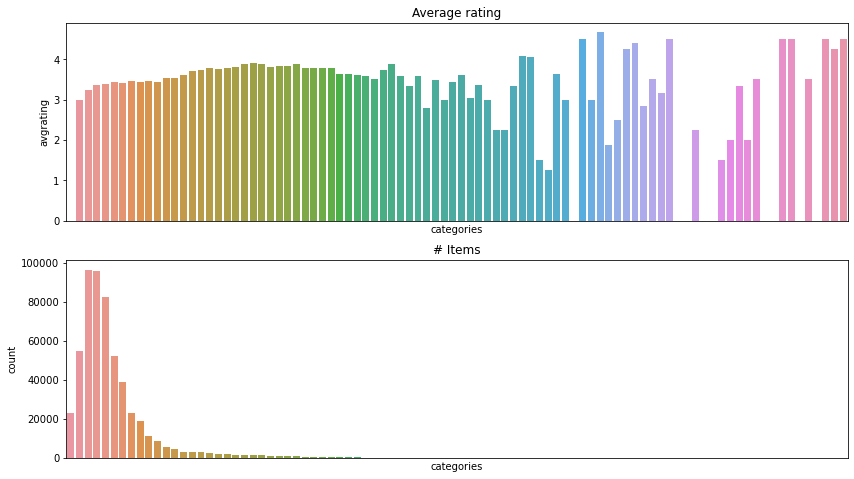

In [27]:
_, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

sns.barplot(data=desc, x='categories', y='avgrating', ci=None, ax=ax[0])
sns.countplot(data=desc, x='categories', ax=ax[1])

ax[1].set_xticks([])

ax[0].set_title('Average rating')
ax[1].set_title('# Items')
plt.show()

In [10]:
desc[['totalreviews', 'avgrating']].corr()

,totalreviews,avgrating
totalreviews,1.000000,0.093652
avgrating,0.093652,1.000000


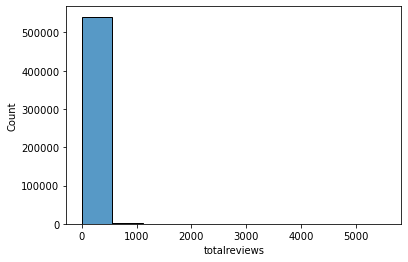

In [10]:
sns.histplot(data=desc, x='totalreviews', bins=10);

<AxesSubplot:>

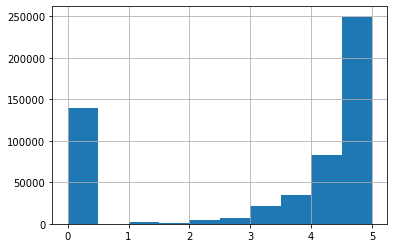

In [ ]:
desc['avgrating'].hist()

### Network

Reading dataframe and merging with metadata information

In [4]:
df = pd.read_csv('Amazon0302.txt', skiprows=4, header=None, sep='\t', names=['from', 'to'])

In [5]:
# Join the link data with the meta data. The joined data contains the description for
# from node product as well as to node product.
df = (
    df
    .merge(desc, left_on=['from'], right_on=['Id'], suffixes=['.1', '.from'])
    .merge(desc, left_on=['to'], right_on=['Id'], suffixes=['.from', '.to'])
)

In [13]:
df.head(3)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
2,16,4,16,War at Sea: A Naval History of World War II,Book,3,10,4.5,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


## EDA

Basic exploratory analysis

In [6]:
print('Unique titles:', desc['title'].nunique())
print('Unique Categories:', desc['categories'].nunique())

Unique titles: 499776
Unique Categories: 90


In [6]:
desc['group'].value_counts()

Book     393561
Music    103143
Video     26131
DVD       19828
Name: group, dtype: int64

In [15]:
df.shape

(1207262, 14)

In [12]:
df.head(3)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
2,16,4,16,War at Sea: A Naval History of World War II,Book,3,10,4.5,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


## Creating graph

### Vertices

In [6]:
# creating weight for edges
# avgrating performed better and indicates the strenght of higher ratings

df['avgrating'] = df['avgrating.from'] * df['avgrating.to']

In [7]:
g = ig.Graph.DataFrame(df[['from', 'to', 'avgrating']], directed=False)

In [17]:
# number os nodes and vertices for the raw network
g.summary()

'IGRAPH UN-- 259092 1207262 -- \n+ attr: name (v), avgrating (e)'

In [17]:
print(g.density())

3.596873762484941e-05


In [18]:
g.transitivity_avglocal_undirected()

0.4294793268176593

In [ ]:
g_summary = pd.DataFrame({
    'degree': g.degree(),
    'transitivity': g.transitivity_local_undirected()
}) 

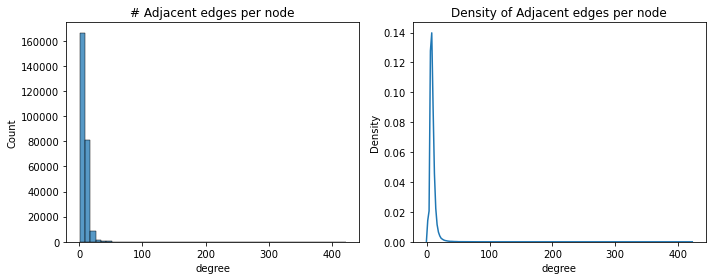

In [18]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('# Adjacent edges per node')
ax[1].set_title('Density of Adjacent edges per node')

sns.histplot(data=g_summary, x='degree', bins=50, ax=ax[0])
sns.kdeplot(data=g_summary, x='degree', ax=ax[1])
plt.tight_layout();

In [26]:
# cumulated normalized frequency for the top 10 degrees
(
    g_summary['degree'].
    value_counts(1).
    sort_index().
    cumsum().
    head(10)
)

1     0.010182
2     0.026689
3     0.042468
4     0.064004
5     0.092168
6     0.231636
7     0.387025
8     0.525555
9     0.641780
10    0.734349
Name: degree, dtype: float64

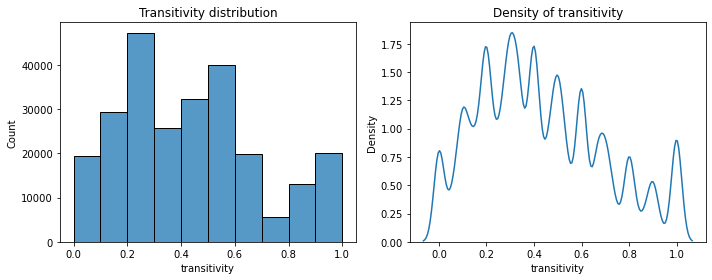

In [15]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('Transitivity distribution')
ax[1].set_title('Density of transitivity')

sns.histplot(data=g_summary, x='transitivity', bins=10, ax=ax[0])
sns.kdeplot(data=g_summary, x='transitivity', ax=ax[1])
plt.tight_layout();

## Clustering

Selecting only the highest connected network

In [8]:
cc = g.clusters(mode='weak')
print('# connected components', len(cc))

# connected components 22


In [9]:
cc = np.array(
    sorted(cc, key=len, reverse=True), dtype='object'
)

In [10]:
print('Top 5 connected networks')
[len(cc[i]) for i in range(5)]

Top 5 connected networks


[258958, 22, 15, 13, 11]

In [11]:
g = g.subgraph(cc[0])

In [12]:
# number of nodes and vertices for the most connected network
g.summary()

'IGRAPH UN-- 258958 1206732 -- \n+ attr: name (v), avgrating (e)'

For each algorithm, we fitted the models on the network considering the weights created and without considering them for means of comparison

### Leiden

In [47]:
start = time.time()
coms_leid_raw = g.community_leiden()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_leid_raw.modularity)

Time elapsed: 4.323301076889038
Modularity: 0.41210093782920315


In [48]:
start = time.time()
coms_leid_w = g.community_leiden(weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_leid_w.modularity)

Time elapsed: 3.2285406589508057
Modularity: 0.8016888158036107


### Louvain

In [49]:
start = time.time()
coms_louv_raw = g.community_multilevel()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_louv_raw.modularity)

Time elapsed: 6.170644044876099
Modularity: 0.9155484245803982


In [50]:
start = time.time()
coms_louv_w = g.community_multilevel(weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_louv_w.modularity)

Time elapsed: 6.315048933029175
Modularity: 0.9302381990619313


### Infomap

In [51]:
start = time.time()
coms_info_raw = g.community_infomap()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_info_raw.modularity)

Time elapsed: 926.2333419322968
Modularity: 0.2387077116264778


In [58]:
start = time.time()
coms_info_w = g.community_infomap(edge_weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_info_w.modularity)

Time elapsed: 556.3165123462677
Modularity: 0.305513656724806


### Save community

In [139]:
coms = {
    'leiden_raw': coms_leid_raw,
    'leiden_weighted': coms_leid_w,
    'louvain_raw': coms_louv_raw,
    'louvain_weighted': coms_louv_w,
    'infomap_raw': coms_info_raw,
    'infomap_weighted': coms_info_w
}

We saved the trained algorithms into a pickle file

In [13]:
# with open('coms.pkl', 'wb') as f:
#     pickle.dump(coms, f)

with open('coms.pkl', 'rb') as f:
    coms = pickle.load(f)

## Analysis

### Hub domain

In [132]:
df_coms = pd.DataFrame({
    'Id': g.vs()['name'],
    'degree': g.degree(),
    'transitivity': g.transitivity_local_undirected()
})

names = ['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']

In [133]:
for i, j in coms.items():
    df_coms[i] = j.membership

hubdom = {}
for i in names:
    df = df_coms[['Id',f'{i}', 'degree', 'transitivity']]
    df['count'] = df.groupby(f'{i}')[f'{i}'].transform('size')

    df['degree_value'] = df['degree'] / df['count']

    df = df.loc[df.groupby(f'{i}')['degree_value'].idxmax()]
    df['hubdom_value'] = (df['degree_value']-df['degree_value'].min())/(df['degree_value'].max()-df['degree_value'].min())

    hubdom.update({f'{i}-hub':df})

Create scatterplot to show hub dominance with respect to transitivity

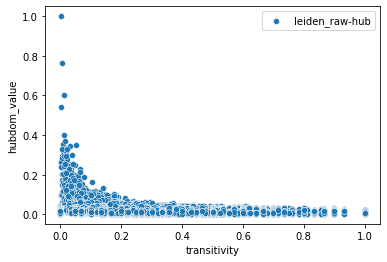

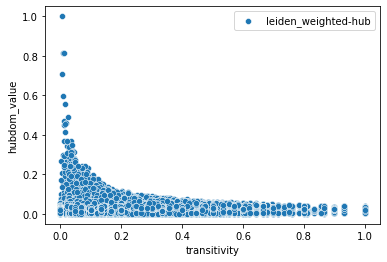

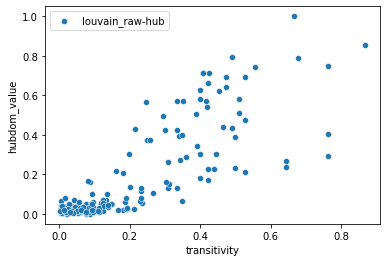

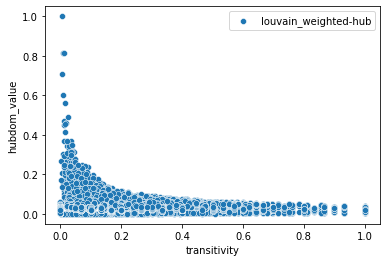

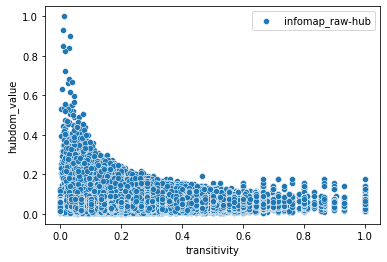

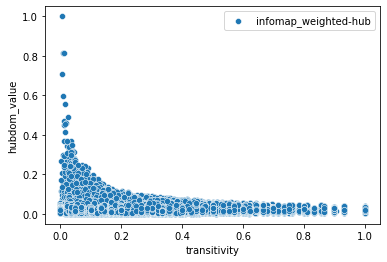

In [135]:
for k,v in hubdom.items():
    plt.figure(k)
    sns.scatterplot(data=hubdom[f'{k}'], x="transitivity", y="hubdom_value", label=k)

### NMI and Adjusted rand comparison

In [136]:
comb_names_1 = []
comb_names_2 = []
comb_nmi = []
comb_rand = []

for n, c in zip(itertools.combinations(coms.keys(), 2), itertools.combinations(coms.values(), 2)):
    comb_names_1.append(f'{n[0]}')
    comb_names_2.append(f'{n[1]}')
    comb_nmi.append(ig.compare_communities(c[0], c[1], method='nmi'))
    comb_rand.append(ig.compare_communities(c[0], c[1], method='adjusted_rand'))

In [137]:
df_comb = pd.DataFrame({
    'algorithm_1': comb_names_1,
    'algorithm_2': comb_names_2,
    'nmi': comb_nmi,
    'adjusted_rand': comb_rand
}, index=comb_names_1).sort_values('nmi')

df_comb

,algorithm_1,algorithm_2,nmi,adjusted_rand
louvain_raw,louvain_raw,infomap_weighted,0.543463,0.001682
louvain_raw,louvain_raw,infomap_raw,0.552436,0.001810
leiden_raw,leiden_raw,louvain_raw,0.558492,0.000931
leiden_weighted,leiden_weighted,louvain_raw,0.575382,0.003226
louvain_raw,louvain_raw,louvain_weighted,0.586484,0.297765
louvain_weighted,louvain_weighted,infomap_raw,0.710586,0.002263
leiden_raw,leiden_raw,louvain_weighted,0.723267,0.001205
louvain_weighted,louvain_weighted,infomap_weighted,0.758176,0.004159
leiden_weighted,leiden_weighted,louvain_weighted,0.794863,0.008179
leiden_weighted,leiden_weighted,infomap_raw,0.903192,0.151666


algorithm_2       infomap_raw  infomap_weighted  leiden_weighted  louvain_raw  \
algorithm_1                                                                     
infomap_raw               NaN          0.911587              NaN          NaN   
leiden_raw           0.922277          0.915724         0.929254     0.558492   
leiden_weighted      0.903192          0.925663              NaN     0.575382   
louvain_raw          0.552436          0.543463              NaN          NaN   
louvain_weighted     0.710586          0.758176              NaN          NaN   

algorithm_2       louvain_weighted  
algorithm_1                         
infomap_raw                    NaN  
leiden_raw                0.723267  
leiden_weighted           0.794863  
louvain_raw               0.586484  
louvain_weighted               NaN  


[Text(0.5, 1.0, 'NMI Heatmap'),
 Text(0.5, 14.09375, 'detection algorithms'),
 Text(32.09374999999999, 0.5, 'detection algorithms')]

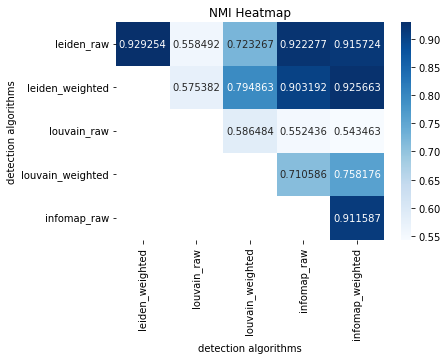

In [138]:
resultnmi = df_comb.pivot(index='algorithm_1', columns='algorithm_2', values='nmi')

print(resultnmi)

resultnmi = resultnmi[['leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']]
resultnmi = resultnmi.reindex(['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw'])

ax = sns.heatmap(resultnmi, annot=True, fmt="g", cmap='Blues')
ax.set(title='NMI Heatmap', xlabel='detection algorithms', ylabel='detection algorithms')

algorithm_2       infomap_raw  infomap_weighted  leiden_weighted  louvain_raw  \
algorithm_1                                                                     
infomap_raw               NaN              0.16              NaN          NaN   
leiden_raw               0.13              0.07             0.22          0.0   
leiden_weighted          0.15              0.22              NaN          0.0   
louvain_raw              0.00              0.00              NaN          NaN   
louvain_weighted         0.00              0.00              NaN          NaN   

algorithm_2       louvain_weighted  
algorithm_1                         
infomap_raw                    NaN  
leiden_raw                    0.00  
leiden_weighted               0.01  
louvain_raw                   0.30  
louvain_weighted               NaN  


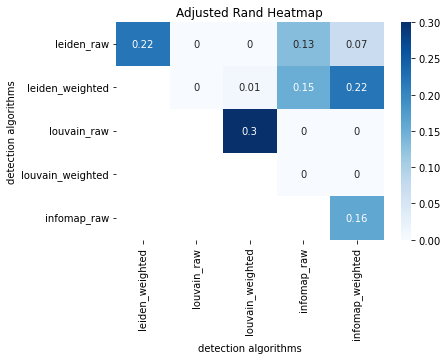

In [141]:
resultrand = df_comb.pivot(index='algorithm_1', columns='algorithm_2', values='adjusted_rand').round(decimals=2)

print(resultrand)

resultrand = resultrand[['leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']]
resultrand = resultrand.reindex(['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw'])

ax = sns.heatmap(resultrand, annot=True, fmt="g", cmap='Blues')
ax.set(title='Adjusted Rand Heatmap', xlabel='detection algorithms', ylabel='detection algorithms');

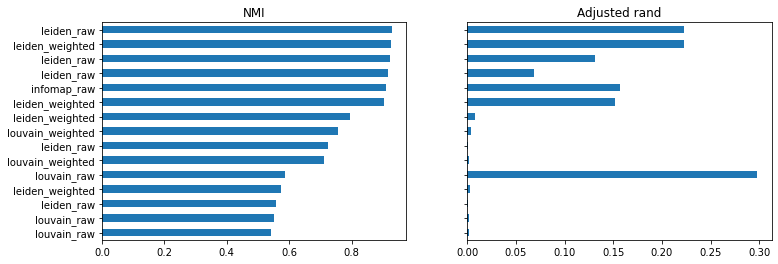

In [140]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
df_comb['nmi'].plot.barh(title='NMI', ax=ax[0])
df_comb['adjusted_rand'].plot.barh(title='Adjusted rand', ax=ax[1]);

### Evaluating communities

In [14]:
df_coms = pd.DataFrame({
    'Id': g.vs()['name']
})

In [15]:
for i, j in coms.items():
    df_coms[i] = j.membership

In [14]:
# number of unique communities per algorithm
df_coms.nunique()

Id                  258958
leiden_raw          113844
leiden_weighted      92377
louvain_raw            198
louvain_weighted     72698
infomap_raw          82429
infomap_weighted    119043
dtype: int64

Community sizes

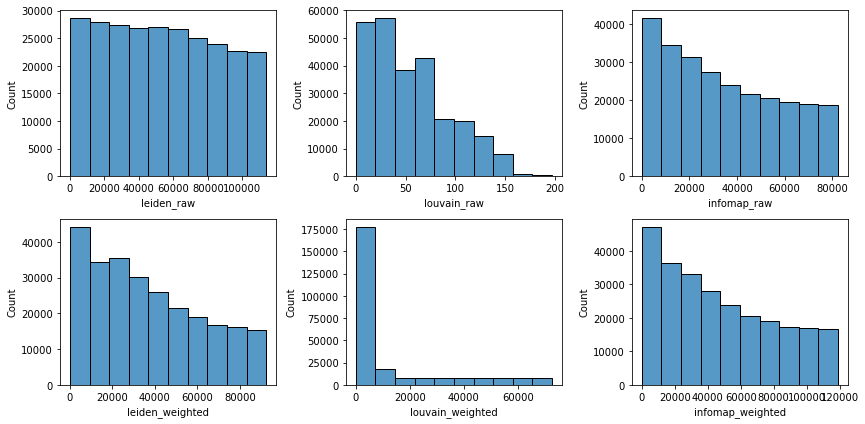

In [17]:
_, ax = plt.subplots(2, 3, figsize=(12, 6))

sns.histplot(data=df_coms, x='leiden_raw', ax=ax[0, 0], bins=10)
sns.histplot(data=df_coms, x='louvain_raw', ax=ax[0, 1], bins=10)
sns.histplot(data=df_coms, x='infomap_raw', ax=ax[0, 2], bins=10)

sns.histplot(data=df_coms, x='leiden_weighted', ax=ax[1, 0], bins=10)
sns.histplot(data=df_coms, x='louvain_weighted', ax=ax[1, 1], bins=10)
sns.histplot(data=df_coms, x='infomap_weighted', ax=ax[1, 2], bins=10)

plt.tight_layout();

In [17]:
df_coms_summary = pd.DataFrame({
    'modularity': [i.modularity for i in coms.values()],
    'communities': [len(set(i.membership)) for i in coms.values()]
}, index=coms.keys()).sort_values('modularity')

In [18]:
# number of unique communities
df_coms_summary

,modularity,communities
infomap_raw,0.238708,82429
infomap_weighted,0.305514,119043
leiden_raw,0.412101,113844
leiden_weighted,0.801689,92377
louvain_raw,0.915548,198
louvain_weighted,0.930238,72698


Louvain weighted presented the highest modularity and showed 72698 communities

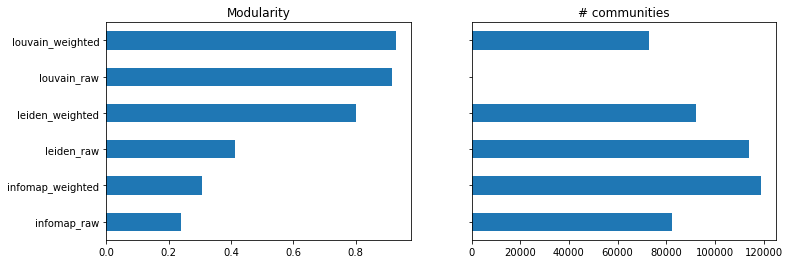

In [151]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

df_coms_summary['modularity'].plot.barh(title='Modularity', ax=ax[0])
df_coms_summary['communities'].plot.barh(title='# communities', ax=ax[1]);

## Visualization

In [142]:
coms_louv_raw = coms['louvain_raw']

In [144]:
k = len(coms_louv_raw.sizes())
print('number of unique communities:', k)

number of unique communities: 198


In [145]:
colors = np.random.permutation(sns.color_palette('hls', k)).tolist()

In [146]:
g.vs['color'] = ['None']

In [147]:
for clid, cluster in enumerate(coms_louv_raw):
    for i in cluster:
        g.vs[i]['color'] = colors[clid]

In [148]:
layout_fr = g.layout('fr')

In [149]:
visual_style = {
    #Define style from network plotting
    "vertex_size": 5,
    "vertex_label": None,
    "vertex_color": g.vs['color'],
    "layout": layout_fr,
    "edge_width": 1
}

fig = ig.plot(g, **visual_style)

In [150]:
fig.save('louv_raw_communities.png')